# 와인2

## 0.과제

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

from sklearn.ensemble import RandomForestClassifier

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/와인/train.csv')
test = pd.read_csv('/content/drive/MyDrive/와인/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/와인/sample_submission.csv')

### 1) 데이터 전처리

In [ ]:
train['type'] = train['type'].map(lambda x : 0 if x == 'white' else 1)

In [ ]:
train = train.append(train[train['quality'].isin([4,7,8])])
train['quality'].value_counts().sort_index()

3      26
4     372
5    1788
6    2416
7    1848
8     304
9       5
Name: quality, dtype: int64

In [ ]:
import numpy as np

def ACC(true, pred):   
    score = np.mean(true==pred)
    return score

In [ ]:
def make_plot():

  acc = ACC(y_valid, y_pred)

  validation = pd.DataFrame({'y_valid':y_valid, 'y_pred':y_pred})

  validation_count = pd.DataFrame(validation['y_valid'].value_counts().sort_index())
  validation_count.loc[validation['y_pred'].value_counts().sort_index().index, 'y_pred'] = validation['y_pred'].value_counts().sort_index()
  validation_count = validation_count.fillna(0)

  x = validation_count.index
  y_valid_count = validation_count['y_valid']
  y_pred_count = validation_count['y_pred']

  width = 0.35

  plt.figure(dpi=150)

  plt.title('ACC : ' + str(acc)[:6])
  plt.xlabel('quality')
  plt.ylabel('count')

  p1 = plt.bar([idx-width/2 for idx in x], y_valid_count, width, label='real')
  p2 = plt.bar([idx+width/2 for idx in x], y_pred_count,  width, label='pred')

  plt.legend()
  plt.show()

In [ ]:
features = train.columns[2:]

In [ ]:
X = train[features]
y = train['quality']

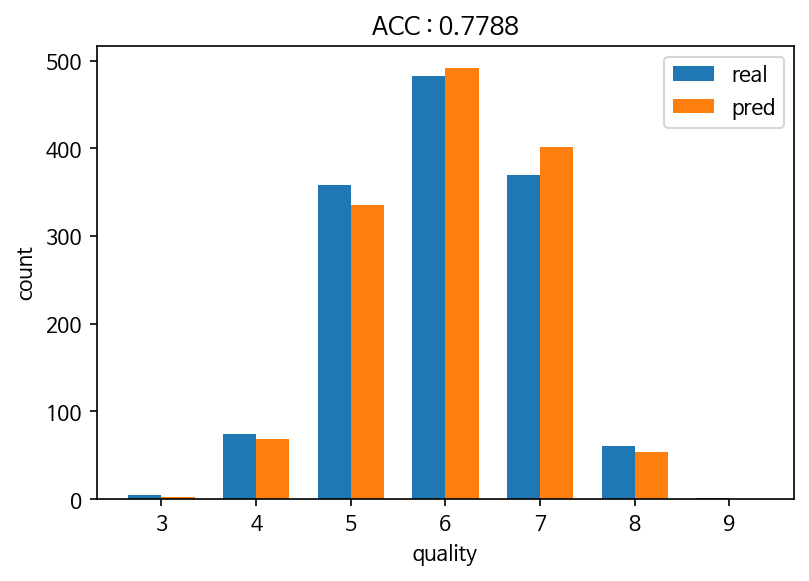

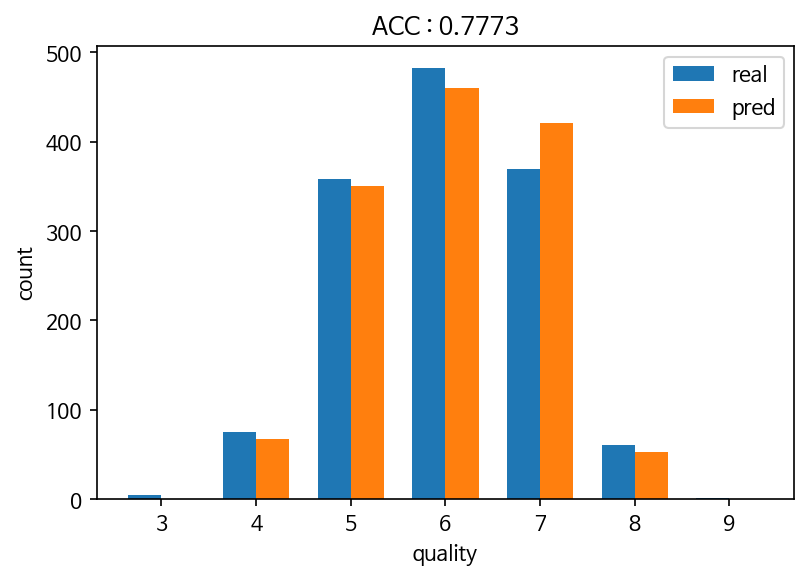

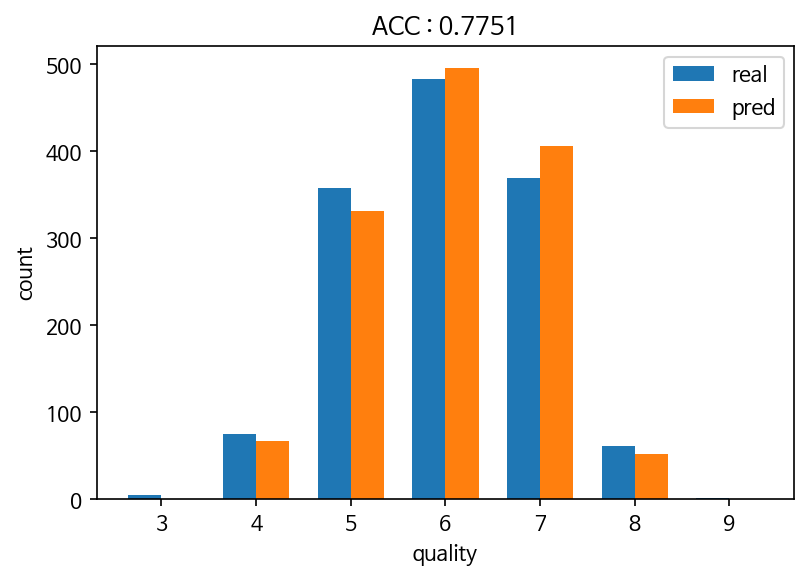

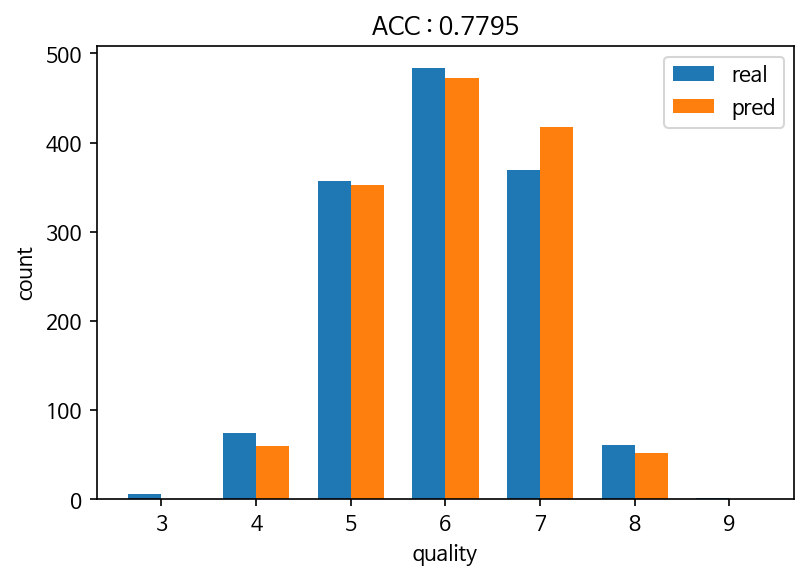

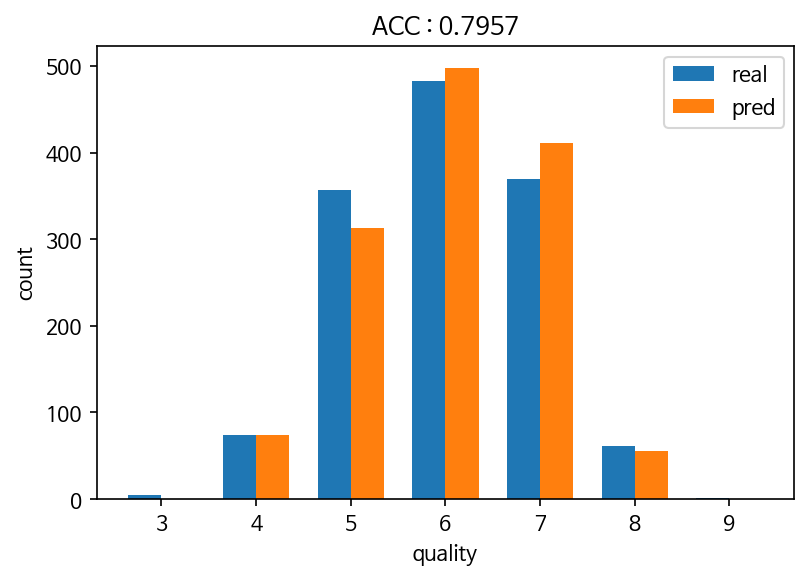

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle = True)
# 추가
models = []
for train_idx, valid_idx in kfold.split(X, y):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

  model = RandomForestClassifier()

  model.fit(X_train, y_train)

  #추가
  models.append(model)

  y_pred = model.predict(X_valid)

  make_plot()

In [ ]:
test['type'] = test['type'].map(lambda x : 0 if x == 'white' else 1)

In [ ]:
pred0 = models[0].predict(test[features])
pred1 = models[1].predict(test[features])
pred2 = models[2].predict(test[features])
pred3 = models[3].predict(test[features])
pred4 = models[4].predict(test[features])

### 2) 하드 보팅

In [ ]:
pred = pd.DataFrame({'pred0':pred0, 'pred1':pred1, 'pred2':pred2, 'pred3':pred3, 'pred4':pred4})
pred

,pred0,pred1,pred2,pred3,pred4
0,5,6,5,6,5
1,5,6,6,6,5
2,6,6,6,5,6
3,5,5,6,5,5
4,6,6,6,7,6
...,...,...,...,...,...
995,6,6,6,5,6
996,6,6,5,6,6
997,5,5,5,5,5
998,6,6,6,6,6


In [ ]:
pred['pred'] = pred.mode(axis=1)[0].astype(int)
pred

,pred0,pred1,pred2,pred3,pred4,pred
0,5,6,5,6,5,5
1,5,6,6,6,5,6
2,6,6,6,5,6,6
3,5,5,6,5,5,5
4,6,6,6,7,6,6
...,...,...,...,...,...,...
995,6,6,6,5,6,6
996,6,6,5,6,6,6
997,5,5,5,5,5,5
998,6,6,6,6,6,6


In [ ]:
submission['quality'] = pred.mode(axis=1)[0].astype(int)
submission

,index,quality
0,0,5
1,1,6
2,2,6
3,3,5
4,4,6
...,...,...
995,995,6
996,996,6
997,997,5
998,998,6


In [ ]:
submission.to_csv('submission.csv', index=False)

# 점수 : 0.689

### 3) 소프트 보팅

In [ ]:
pred0 = models[0].predict_proba(test[features])
pred0

array([[0.  , 0.08, 0.39, ..., 0.13, 0.04, 0.  ],
       [0.04, 0.09, 0.43, ..., 0.03, 0.  , 0.  ],
       [0.  , 0.05, 0.35, ..., 0.07, 0.03, 0.  ],
       ...,
       [0.01, 0.07, 0.55, ..., 0.04, 0.02, 0.  ],
       [0.  , 0.08, 0.2 , ..., 0.04, 0.02, 0.  ],
       [0.01, 0.  , 0.04, ..., 0.17, 0.02, 0.  ]])

In [ ]:
pd.DataFrame(pred0)

,0,1,2,3,4,5,6
0,0.00,0.08,0.39,0.36,0.13,0.04,0.00
1,0.04,0.09,0.43,0.41,0.03,0.00,0.00
2,0.00,0.05,0.35,0.50,0.07,0.03,0.00
3,0.00,0.01,0.73,0.18,0.08,0.00,0.00
4,0.00,0.01,0.05,0.55,0.35,0.04,0.00
...,...,...,...,...,...,...,...
995,0.00,0.02,0.27,0.70,0.01,0.00,0.00
996,0.00,0.05,0.29,0.46,0.18,0.01,0.01
997,0.01,0.07,0.55,0.31,0.04,0.02,0.00
998,0.00,0.08,0.20,0.66,0.04,0.02,0.00


In [ ]:
pred0 = models[0].predict_proba(test[features])
pred1 = models[1].predict_proba(test[features])
pred2 = models[2].predict_proba(test[features])
pred3 = models[3].predict_proba(test[features])
pred4 = models[4].predict_proba(test[features])

In [ ]:
pred = pd.DataFrame((pred0 + pred1 + pred2 + pred3 + pred4)/5)
pred

,0,1,2,3,4,5,6
0,0.006,0.146,0.302,0.348,0.146,0.052,0.000
1,0.040,0.116,0.424,0.400,0.020,0.000,0.000
2,0.010,0.042,0.318,0.572,0.044,0.014,0.000
3,0.002,0.024,0.622,0.264,0.088,0.000,0.000
4,0.000,0.030,0.054,0.484,0.398,0.028,0.006
...,...,...,...,...,...,...,...
995,0.004,0.022,0.380,0.592,0.002,0.000,0.000
996,0.000,0.050,0.336,0.440,0.158,0.012,0.004
997,0.010,0.086,0.560,0.308,0.030,0.006,0.000
998,0.000,0.052,0.152,0.720,0.062,0.014,0.000


In [ ]:
pd.DataFrame(np.argmax(np.array(pred), axis=1))

,0
0,3
1,2
2,3
3,2
4,3
...,...
995,3
996,3
997,2
998,3


In [ ]:
pred['quality'] = np.argmax(np.array(pred), axis=1)
pred

,0,1,2,3,4,5,6,quality
0,0.006,0.146,0.302,0.348,0.146,0.052,0.000,3
1,0.040,0.116,0.424,0.400,0.020,0.000,0.000,2
2,0.010,0.042,0.318,0.572,0.044,0.014,0.000,3
3,0.002,0.024,0.622,0.264,0.088,0.000,0.000,2
4,0.000,0.030,0.054,0.484,0.398,0.028,0.006,3
...,...,...,...,...,...,...,...,...
995,0.004,0.022,0.380,0.592,0.002,0.000,0.000,3
996,0.000,0.050,0.336,0.440,0.158,0.012,0.004,3
997,0.010,0.086,0.560,0.308,0.030,0.006,0.000,2
998,0.000,0.052,0.152,0.720,0.062,0.014,0.000,3


In [ ]:
pred['quality'] = pred['quality'] + 3
pred

,0,1,2,3,4,5,6,quality
0,0.006,0.146,0.302,0.348,0.146,0.052,0.000,6
1,0.040,0.116,0.424,0.400,0.020,0.000,0.000,5
2,0.010,0.042,0.318,0.572,0.044,0.014,0.000,6
3,0.002,0.024,0.622,0.264,0.088,0.000,0.000,5
4,0.000,0.030,0.054,0.484,0.398,0.028,0.006,6
...,...,...,...,...,...,...,...,...
995,0.004,0.022,0.380,0.592,0.002,0.000,0.000,6
996,0.000,0.050,0.336,0.440,0.158,0.012,0.004,6
997,0.010,0.086,0.560,0.308,0.030,0.006,0.000,5
998,0.000,0.052,0.152,0.720,0.062,0.014,0.000,6


## 1.EDA-features

In [ ]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0
1,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1
2,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0
3,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0
4,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,1
5482,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,0
5485,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,0
5491,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,0


In [ ]:
def make_plots(text:str):
  plt.title(text + ' vs quality')

  x = train.groupby('quality').mean().reset_index()['quality']
  y = train.groupby('quality').mean().reset_index()[text]

  plt.bar(x,y)
  plt.show()

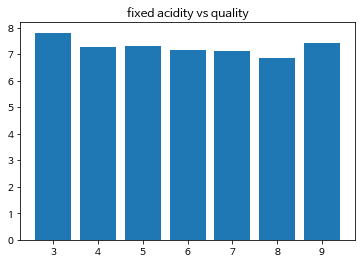

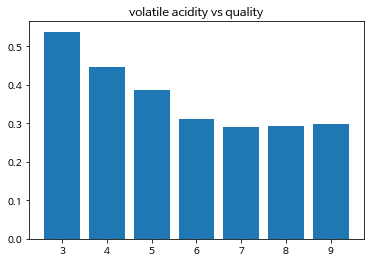

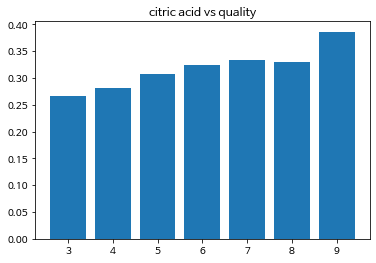

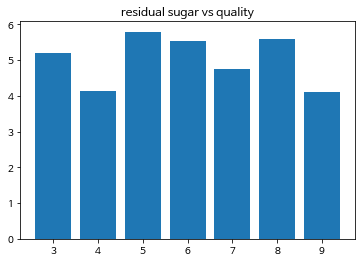

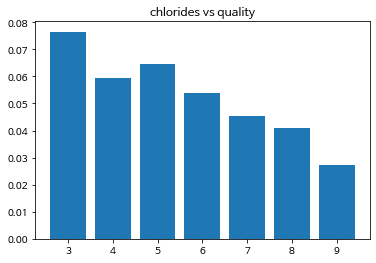

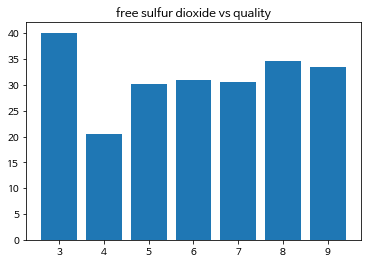

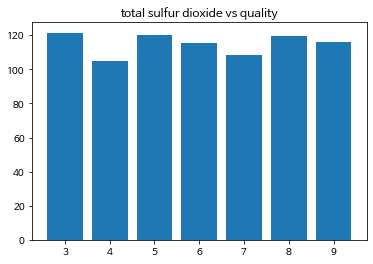

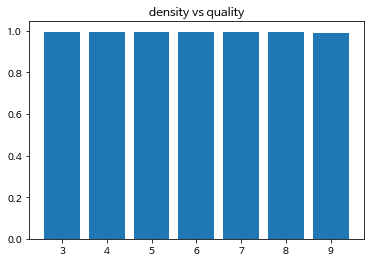

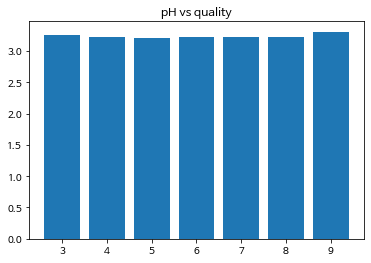

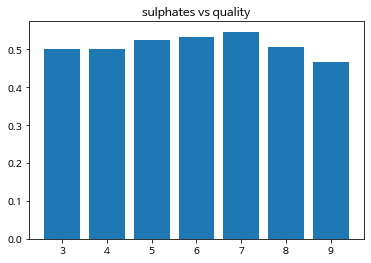

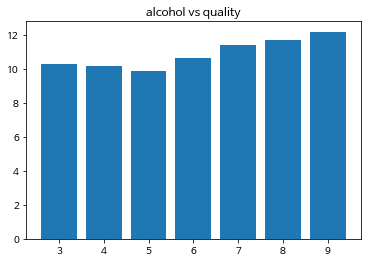

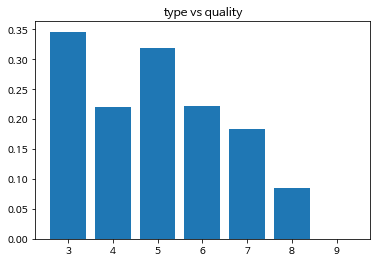

In [ ]:
for col in train.groupby('quality').mean().reset_index().columns[2:]:
  make_plots(col)

## 2.데이터 전처리 기법

### 1) one-hot encoding

In [ ]:
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,1
5482,5482,4,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,0
5485,5485,4,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,0
5491,5491,7,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,0


In [ ]:
train['type'] = train['type'].map(lambda x : 'white' if x == 0 else 'red')

In [ ]:
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,red
5482,5482,4,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,white
5485,5485,4,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,white
5491,5491,7,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,white


In [ ]:
train = pd.concat([train,pd.get_dummies(train['type'])], axis=1)
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white,0,1
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red,1,0
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white,0,1
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white,0,1
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,red,1,0
5482,5482,4,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,white,0,1
5485,5485,4,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,white,0,1
5491,5491,7,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,white,0,1


In [ ]:
train.columns[2:-3]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

### 2) 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train[train.columns[2:-3]] = scaler.fit_transform(train[train.columns[2:-3]])
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,5,0.148760,0.410000,0.036145,0.095092,0.054908,0.027778,0.179724,0.139001,0.551181,0.123596,0.318841,white,0,1
1,1,5,0.413223,0.353333,0.084337,0.027607,0.096506,0.031250,0.082949,0.188741,0.354331,0.207865,0.217391,red,1,0
2,2,5,0.338843,0.086667,0.234940,0.021472,0.079867,0.069444,0.304147,0.089647,0.244094,0.168539,0.420290,white,0,1
3,3,6,0.264463,0.086667,0.186747,0.082822,0.061564,0.097222,0.235023,0.130904,0.409449,0.157303,0.405797,white,0,1
4,4,6,0.330579,0.213333,0.156627,0.136503,0.083195,0.107639,0.396313,0.161751,0.236220,0.117978,0.420290,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,0.132231,0.503333,0.048193,0.009202,0.061564,0.041667,0.200461,0.101986,0.653543,0.353933,0.724638,red,1,0
5482,5482,4,0.198347,0.233333,0.295181,0.088957,0.059900,0.038194,0.251152,0.177174,0.417323,0.196629,0.144928,white,0,1
5485,5485,4,0.206612,0.133333,0.132530,0.136503,0.051581,0.100694,0.241935,0.120879,0.244094,0.050562,0.405797,white,0,1
5491,5491,7,0.256198,0.173333,0.180723,0.062883,0.033278,0.114583,0.327189,0.087527,0.488189,0.151685,0.623188,white,0,1


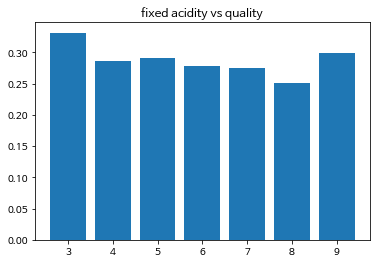

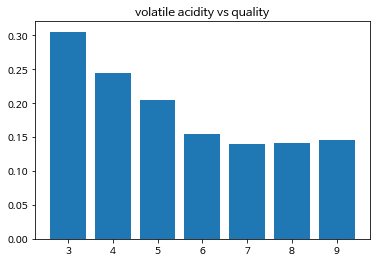

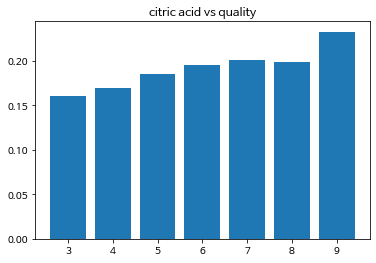

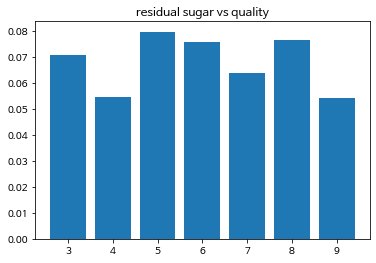

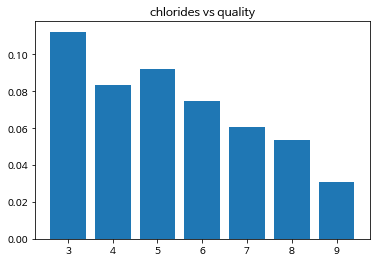

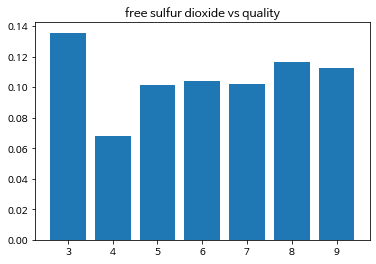

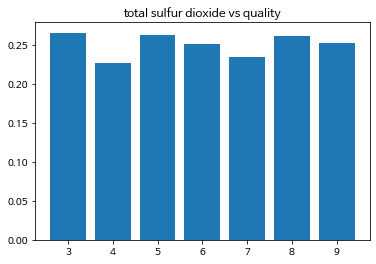

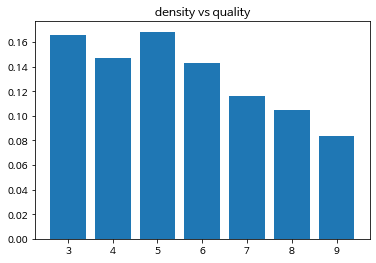

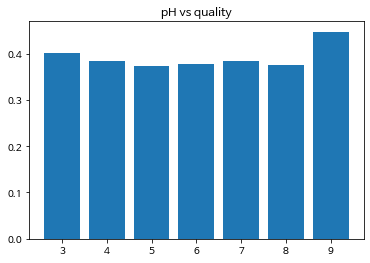

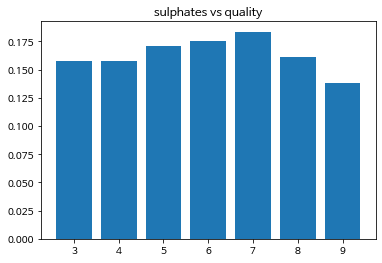

In [ ]:
for col in train.groupby('quality').mean().reset_index().columns[2:-3]:
  make_plots(col)

In [ ]:
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,5,0.148760,0.410000,0.036145,0.095092,0.054908,0.027778,0.179724,0.139001,0.551181,0.123596,0.318841,white,0,1
1,1,5,0.413223,0.353333,0.084337,0.027607,0.096506,0.031250,0.082949,0.188741,0.354331,0.207865,0.217391,red,1,0
2,2,5,0.338843,0.086667,0.234940,0.021472,0.079867,0.069444,0.304147,0.089647,0.244094,0.168539,0.420290,white,0,1
3,3,6,0.264463,0.086667,0.186747,0.082822,0.061564,0.097222,0.235023,0.130904,0.409449,0.157303,0.405797,white,0,1
4,4,6,0.330579,0.213333,0.156627,0.136503,0.083195,0.107639,0.396313,0.161751,0.236220,0.117978,0.420290,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,0.132231,0.503333,0.048193,0.009202,0.061564,0.041667,0.200461,0.101986,0.653543,0.353933,0.724638,red,1,0
5482,5482,4,0.198347,0.233333,0.295181,0.088957,0.059900,0.038194,0.251152,0.177174,0.417323,0.196629,0.144928,white,0,1
5485,5485,4,0.206612,0.133333,0.132530,0.136503,0.051581,0.100694,0.241935,0.120879,0.244094,0.050562,0.405797,white,0,1
5491,5491,7,0.256198,0.173333,0.180723,0.062883,0.033278,0.114583,0.327189,0.087527,0.488189,0.151685,0.623188,white,0,1


In [ ]:
features = train.columns[2:].drop('type')
features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'red', 'white'],
      dtype='object')

In [ ]:
X = train[features]
y = train['quality']

### 3) 성능 검증

- 랜덤포레스트는 성능이 떨어짐

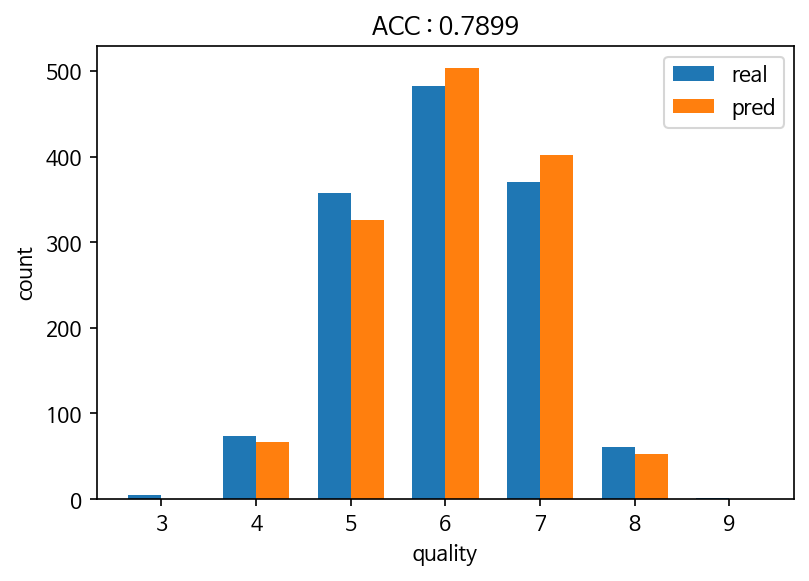

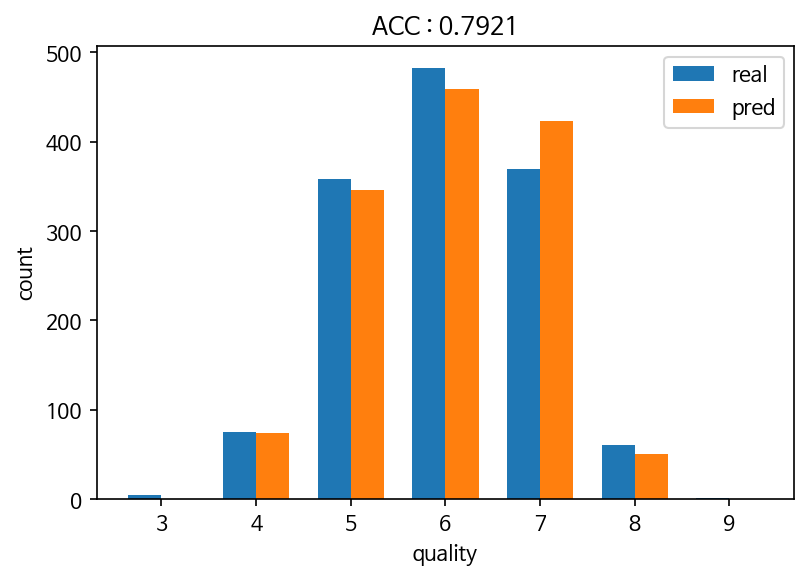

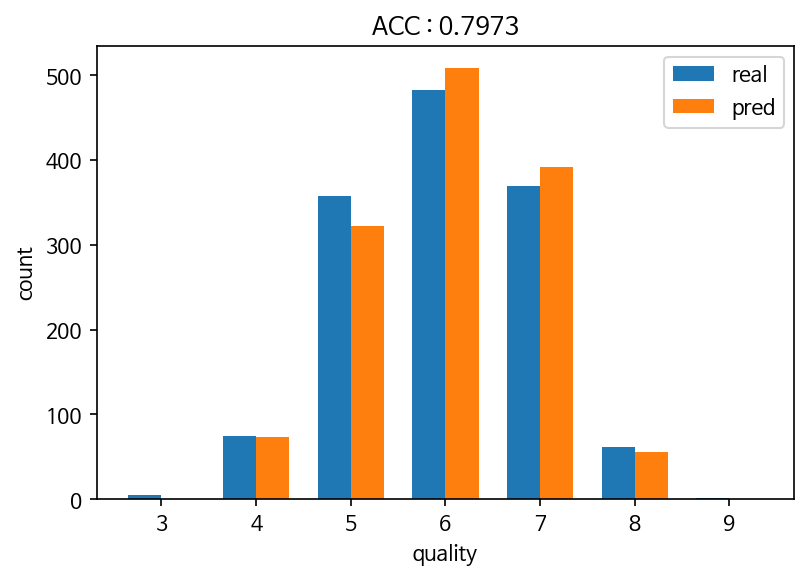

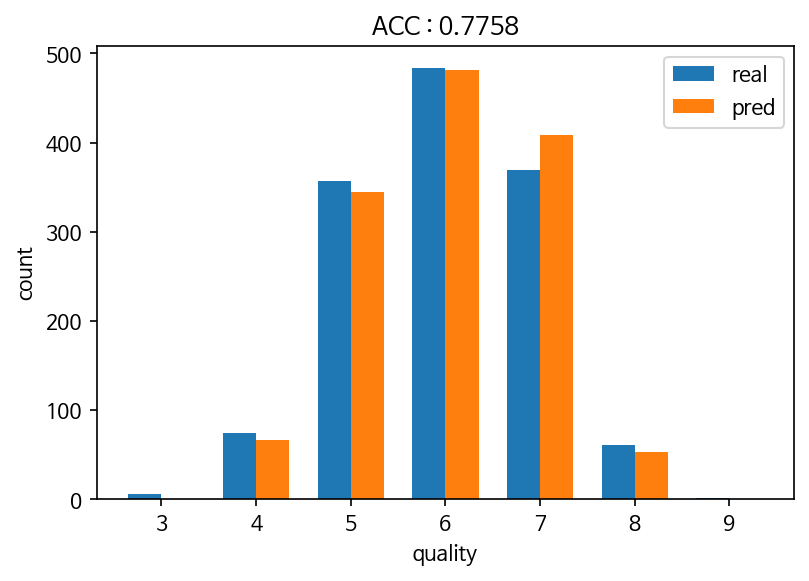

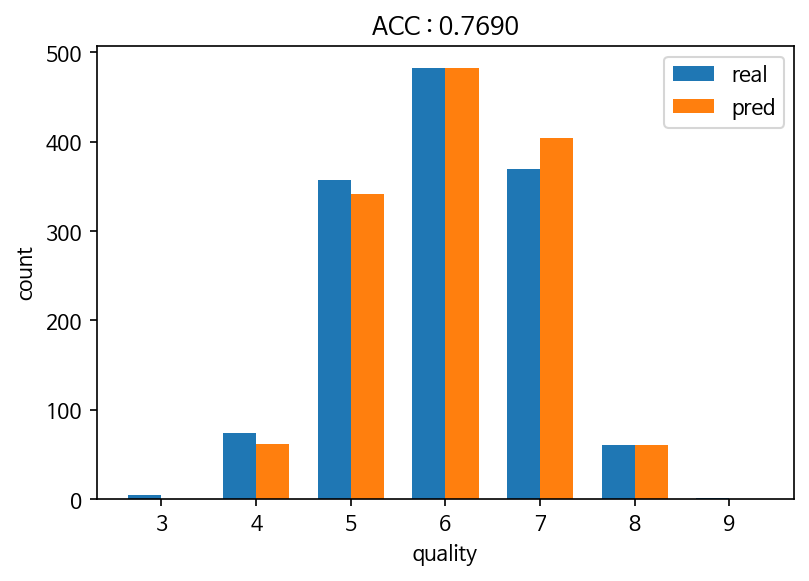

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle = True)
# 추가
models = []
for train_idx, valid_idx in kfold.split(X, y):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

  model = RandomForestClassifier()

  model.fit(X_train, y_train)

  #추가
  models.append(model)

  y_pred = model.predict(X_valid)

  make_plot()

## 3.GridSearchCV

### 1) GridSearchCV로 교차검증과 하이퍼파라미터 튜닝하기

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'n_estimators' : [100, 150, 200],
          'criterion' : ['gini', 'entropy']}

rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, return_train_score=True, verbose=2)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_valid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


[CV] END ...................criterion=gini, n_estimators=100; total time=   2.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.5s
[CV] END ...................criterion=gini, n_estimators=100; total time=   3.4s
[CV] END ...................criterion=gini, n_estimators=100; total time=   3.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.8s
[CV] END ...................criterion=gini, n_estimators=150; total time=   2.6s
[CV] END ...................criterion=gini, n_estimators=150; total time=   2.2s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.9s
[CV] END ...................criterion=gini, n_estimators=150; total time=   2.1s
[CV] END ...................criterion=gini, n_estimators=150; total time=   2.1s
[CV] END ...................criterion=gini, n_estimators=200; total time=   2.1s
[CV] END ...................criterion=gini, n_estimators=200; total time=   1.8s
[CV] END ...................

### 2) validation 셋으로 검증하기

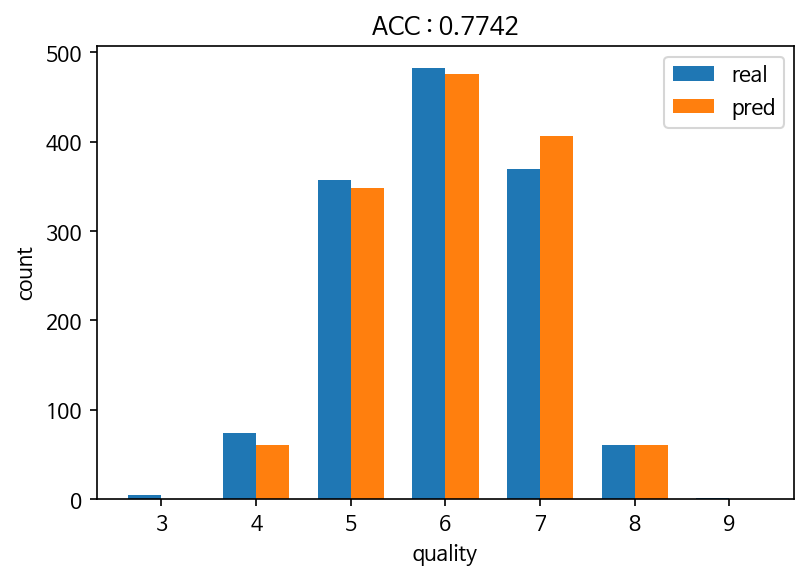

In [ ]:
make_plot()

In [ ]:
rf.best_score_

0.7777369485705882

In [ ]:
rf.best_params_

{'criterion': 'gini', 'n_estimators': 200}

### 3) validation 셋 구축 X

In [ ]:
params = {'n_estimators' : [100, 150, 200],
          'criterion' : ['gini', 'entropy']}

rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, return_train_score=True, verbose=2)

rf.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=200; total time=   2.2s
[CV] END ...................criterion=gini, n_est

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True, verbose=2)

In [ ]:
rf.best_score_

0.824972297531086

In [ ]:
rf.best_params_

{'criterion': 'gini', 'n_estimators': 200}

## 4.모델 앙상블

### 1) GridSearchCV로 모델 학습

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
models = []

rfc = RandomForestClassifier( ) 

models.append(rfc)

gbc = GradientBoostingClassifier( )

models.append(gbc)

etc = ExtraTreesClassifier()

models.append(etc)

In [ ]:
best_models={}
params = [{},{},{}]

for i, model in enumerate(models):
  model = GridSearchCV(model, param_grid=params[i], cv=5, return_train_score=True, verbose=2)
  
  model.fit(X,y)

  best_models[i] = model.best_estimator_
  # best_models.append(model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   8.8s
[CV] END .................................................... total time=   9.5s
[CV] END .................................................... total time=   9.4s
[CV] END .................................................... total time=  10.7s
[CV] END .................................................... total time=   8.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....

### 2) fold별 best_model을 이용해서 커스텀 보팅하기

In [ ]:
best_models

{0: RandomForestClassifier(),
 1: GradientBoostingClassifier(),
 2: ExtraTreesClassifier()}

In [ ]:
test

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,9.0,0.31,0.48,6.60,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,0
1,1,13.3,0.43,0.58,1.90,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,1
2,2,6.5,0.28,0.27,5.20,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,0
3,3,7.2,0.15,0.39,1.80,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,0
4,4,6.8,0.26,0.26,2.00,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,7.1,0.59,0.02,2.30,0.082,24.0,94.0,0.99744,3.55,0.53,9.7,1
996,996,8.7,0.15,0.30,1.60,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,0
997,997,8.8,0.66,0.26,1.70,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,1
998,998,7.0,0.42,0.19,2.30,0.071,18.0,36.0,0.99476,3.39,0.56,10.9,1


In [ ]:
test['type'] = test['type'].map(lambda x : 'white' if x == 0 else 'red')

In [ ]:
test = pd.concat([test,pd.get_dummies(test['type'])], axis=1)
test

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,9.0,0.31,0.48,6.60,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,white,0,1
1,1,13.3,0.43,0.58,1.90,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,red,1,0
2,2,6.5,0.28,0.27,5.20,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,white,0,1
3,3,7.2,0.15,0.39,1.80,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,white,0,1
4,4,6.8,0.26,0.26,2.00,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,7.1,0.59,0.02,2.30,0.082,24.0,94.0,0.99744,3.55,0.53,9.7,red,1,0
996,996,8.7,0.15,0.30,1.60,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,white,0,1
997,997,8.8,0.66,0.26,1.70,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,red,1,0
998,998,7.0,0.42,0.19,2.30,0.071,18.0,36.0,0.99476,3.39,0.56,10.9,red,1,0


In [ ]:
test.columns[1:-3]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [ ]:
test[test.columns[1:-3]] = scaler.transform(test[test.columns[1:-3]])
test

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,0.429752,0.153333,0.289157,0.092025,0.056572,0.034722,0.154378,0.128976,0.125984,0.089888,0.521739,white,0,1
1,1,0.785124,0.233333,0.349398,0.019939,0.101498,0.048611,0.078341,0.256217,0.251969,0.151685,0.144928,red,1,0
2,2,0.223140,0.133333,0.162651,0.070552,0.051581,0.149306,0.398618,0.148255,0.354331,0.264045,0.202899,white,0,1
3,3,0.280992,0.046667,0.234940,0.018405,0.056572,0.069444,0.352535,0.148255,0.614173,0.140449,0.289855,white,0,1
4,4,0.247934,0.120000,0.156627,0.021472,0.016639,0.078125,0.152074,0.063621,0.330709,0.140449,0.550725,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0.272727,0.340000,0.012048,0.026074,0.121464,0.079861,0.202765,0.199152,0.637795,0.174157,0.246377,red,1,0
996,996,0.404959,0.046667,0.180723,0.015337,0.061564,0.097222,0.285714,0.136688,0.377953,0.089888,0.260870,white,0,1
997,997,0.413223,0.386667,0.156627,0.016871,0.108153,0.010417,0.039171,0.192597,0.322835,0.292135,0.173913,red,1,0
998,998,0.264463,0.226667,0.114458,0.026074,0.103161,0.059028,0.069124,0.147484,0.511811,0.191011,0.420290,red,1,0


In [ ]:
pred0 = best_models[0].predict(test[features])
pred1 = best_models[1].predict(test[features])
pred2 = best_models[2].predict(test[features])
pred = pd.DataFrame({'pred0':pred0, 'pred1':pred1, 'pred2':pred2})
pred

,pred0,pred1,pred2
0,5,6,5
1,6,5,6
2,6,5,6
3,5,6,5
4,6,7,6
...,...,...,...
995,6,5,6
996,6,6,6
997,5,5,5
998,6,6,6


In [ ]:
pred['pred'] = pred.mode(axis=1)[0].astype(int)
pred

,pred0,pred1,pred2,pred
0,5,6,5,5
1,6,5,6,6
2,6,5,6,6
3,5,6,5,5
4,6,7,6,6
...,...,...,...,...
995,6,5,6,6
996,6,6,6,6
997,5,5,5,5
998,6,6,6,6


In [ ]:
pred0 = best_models[0].predict_proba(test[features])
pred1 = best_models[1].predict_proba(test[features])
pred2 = best_models[2].predict_proba(test[features])

In [ ]:
pred = pd.DataFrame((pred0 + pred1 + pred2)/3)
pred

,0,1,2,3,4,5,6
0,0.013482,0.149881,0.340667,0.335588,0.114482,0.045893,7.327657e-06
1,0.013746,0.105239,0.439292,0.406874,0.033975,0.000873,2.048901e-06
2,0.000051,0.038278,0.380291,0.511184,0.063826,0.006370,4.048762e-07
3,0.000080,0.021259,0.609363,0.266061,0.097110,0.006126,2.387116e-06
4,0.000041,0.019001,0.085484,0.496178,0.364956,0.027672,6.668229e-03
...,...,...,...,...,...,...,...
995,0.000110,0.014110,0.329282,0.647530,0.008254,0.000714,7.305944e-07
996,0.000089,0.086796,0.261480,0.488009,0.142119,0.021505,1.186233e-06
997,0.000169,0.072162,0.603618,0.278078,0.038347,0.007626,2.778215e-07
998,0.000157,0.061766,0.229144,0.609982,0.094395,0.004554,1.475416e-06


In [ ]:
pd.DataFrame(np.argmax(np.array(pred), axis=1))

,0
0,2
1,2
2,3
3,2
4,3
...,...
995,3
996,3
997,2
998,3


### 3) VotingClassifier 이용한 스태킹 앙상블

In [ ]:
estimators = [
    ('rfc', best_models[0]),
    ('gbc', best_models[1]),
    ('etc', best_models[2])
]

In [ ]:
from sklearn.ensemble import VotingClassifier #앙상블 기법을 위한 패키지를 불러옵니다.

model = VotingClassifier(estimators=estimators, voting='hard') #앙살블 모델을 선언합니다. 디폴트값 Hard Voting Classifier 
model.fit(X, y) #모델을 학습시킵니다

VotingClassifier(estimators=[('rfc', RandomForestClassifier()),
                             ('gbc', GradientBoostingClassifier()),
                             ('etc', ExtraTreesClassifier())])

In [ ]:
from sklearn.ensemble import VotingClassifier #앙상블 기법을 위한 패키지를 불러옵니다.

model = VotingClassifier(estimators=estimators, voting='soft') #앙살블 모델을 선언합니다. 디폴트값 Hard Voting Classifier 
model.fit(X, y) #모델을 학습시킵니다

VotingClassifier(estimators=[('rfc', RandomForestClassifier()),
                             ('gbc', GradientBoostingClassifier()),
                             ('etc', ExtraTreesClassifier())],
                 voting='soft')

In [ ]:
model.score(X,y)

1.0

In [ ]:
submission['quality'] = pd.DataFrame(model.predict(test[features]))
submission

,index,quality
0,0,6
1,1,6
2,2,6
3,3,5
4,4,6
...,...,...
995,995,6
996,996,6
997,997,5
998,998,6


In [ ]:
submission.to_csv('submission.csv', index=False)

#0.699